## gpt에게 생성 부탁

In [ ]:
import openai
import random
import json

# OpenAI API 키 설정
OPENAI_API_KEY = "your_api_key"

# 질문 템플릿 예시
questions_templates = [
    "식물 {plant}의 재배 방법은 무엇인가요?",
    "{plant}는 어떤 환경에서 잘 자라나요?",
    "{plant}의 관리 방법은 무엇인가요?",
    "{plant}의 잎이 노랗게 변했을 때 어떻게 해야 하나요?",
    "{plant}는 물을 얼마나 자주 주어야 하나요?",
    "{plant}의 이상적인 토양 조건은 무엇인가요?",
    "{plant}의 번식 방법은 무엇인가요?"
]

# 식물 목록
plant_types = ["장미", "토마토", "몬스테라", "양치식물", "다육식물", "선인장", "허브"]

# 답변 생성 함수 (새로운 API 적용)
def generate_answer(question):
    client = openai.OpenAI(api_key=OPENAI_API_KEY)  # API 키 포함
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "user", "content": question}
        ],
        max_tokens=150,
        temperature=0.7,
        n=1
    )
    return response.choices[0].message.content.strip()

# 데이터셋 생성 함수
def generate_plant_qa_dataset(num_samples=1000):
    dataset = []
    for _ in range(num_samples):
        plant = random.choice(plant_types)
        question_template = random.choice(questions_templates)
        question = question_template.format(plant=plant)
        answer = generate_answer(question)

        dataset.append({
            "question": question,
            "answer": answer
        })

    return dataset

# 질문-답변 데이터셋 생성
dataset = generate_plant_qa_dataset(num_samples=5)

# 생성된 데이터셋을 JSON 파일로 저장
with open("plant_qa_dataset.json", "w", encoding="utf-8") as f:
    json.dump(dataset, f, ensure_ascii=False, indent=4)

print("질문-답변 데이터셋이 생성되었습니다.")

질문-답변 데이터셋이 생성되었습니다.


## html parser 기반으로 SFT 데이터셋 생성

In [ ]:
# 드라이브 마우트
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/LLM/planty/data/sft_dataset

/content/drive/MyDrive/LLM/planty/data


In [ ]:
!pip install bs4 kss jsonlines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 83.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.9/757.9 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from bs4 import BeautifulSoup
import json
import kss  # 한국어 문장 분리 라이브러리

# HTML 파일 로드 및 텍스트 추출
with open("농사로_분갈이.html", "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

text = soup.get_text()  # HTML에서 텍스트만 추출
sentences = kss.split_sentences(text)  # 한국어 문장 단위로 나누기

# Q&A 자동 생성
dataset = []
for i in range(len(sentences) - 1):
    question = "Q) " + sentences[i]  # 현재 문장을 질문으로
    answer = "A) " + sentences[i + 1]  # 다음 문장을 답변으로
    dataset.append({"question": question, "answer": answer})

# JSON 저장
with open("train_kss.json", "w", encoding="utf-8") as json_file:
    json.dump(dataset, json_file, ensure_ascii=False, indent=4)

print("한국어 Q&A JSON 파일 생성 완료!")

한국어 Q&A JSON 파일 생성 완료!


## gpt 기반 SFT 데이터 생성

### 질문

In [ ]:
import openai
import json

# OpenAI API 키 설정
openai.api_key = "your_api_key"

# 질의응답 자동 생성 (20개 생성)
def generate_qa(text):
    prompt = f"""
    SFT를 위한 학습 데이터를 생성하려고 합니다.
    다음 내용을 기반으로 20개의 Q&A 세트를 만들어 주세요.
    JSON 리스트 형태로 제공해주세요.

    형식 예시:
    [
        {{"question": "Q", "answer": "A"}},
        {{"question": "Q", "answer": "A"}}
    ]

    입력 데이터:
    {text}
    """

    response = openai.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7
    )

    # 응답을 JSON 형태로 변환 (문자열 → 리스트)
    try:
        qa_list = json.loads(response.choices[0].message.content)
    except json.JSONDecodeError as e:
        print("JSON 변환 오류:", e)
        qa_list = []  # 변환 실패 시 빈 리스트 반환

    return qa_list

# HTML에서 텍스트 추출 후 GPT에 입력 (실제 text 사용)
qa_list = generate_qa("분갈이는 언제 해야 하나요?")  # 실제 HTML 데이터로 변경 필요

# JSON 저장 (올바른 리스트 형태)
with open("train_gpt.json", "w", encoding="utf-8") as json_file:
    json.dump(qa_list, json_file, ensure_ascii=False, indent=4)

print("GPT 기반 JSON 생성 완료! (Q&A 20개 저장)")

✅ GPT 기반 JSON 생성 완료! (Q&A 20개 저장)


### html 파일

In [ ]:
import openai
import json
from bs4 import BeautifulSoup

# HTML 파일에서 텍스트 추출 함수
def extract_text_from_html(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "html.parser")
        return soup.get_text(separator="\n", strip=True)

# 질의응답 자동 생성 (20개 생성)
def generate_qa(text):
    prompt = f"""
    SFT를 위한 학습 데이터를 생성하려고 합니다.
    다음 내용을 기반으로 20개의 Q&A 세트를 만들어 주세요.
    JSON 리스트 형태로 제공해주세요.

    형식 예시:
    [
        {{"question": "Q", "answer": "A"}},
        {{"question": "Q", "answer": "A"}}
    ]

    입력 데이터:
    {text}
    """

    response = openai.chat.completions.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7
    )

    # 응답을 JSON 형태로 변환 (문자열 → 리스트)
    try:
        qa_list = json.loads(response.choices[0].message.content)
    except json.JSONDecodeError as e:
        print("JSON 변환 오류:", e)
        qa_list = []  # 변환 실패 시 빈 리스트 반환

    return qa_list

# HTML 파일에서 텍스트 추출
html_text = extract_text_from_html("농사로_분갈이.html")

# GPT에 입력하여 Q&A 데이터 생성
qa_list = generate_qa(html_text)

# JSON 저장 (올바른 리스트 형태)
with open("train_gpt.json", "w", encoding="utf-8") as json_file:
    json.dump(qa_list, json_file, ensure_ascii=False, indent=4)

print("✅ GPT 기반 JSON 생성 완료! (Q&A 20개 저장)")

✅ GPT 기반 JSON 생성 완료! (Q&A 20개 저장)


## groq_api 기반 SFT 데이터셋 생성

In [ ]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 3.1 MB/s eta 0:00:00


### 질문

In [ ]:
import json
import requests
from groq import Groq

# Groq API 키 설정
GROQ_API_KEY = "your_api_key"  # 🔒 API 키를 여기에 입력하세요.

# 질의응답 자동 생성 (20개 생성)
def generate_qa(text):
    prompt = f"""
    SFT를 위한 학습 데이터를 생성하려고 합니다.
    다음 내용을 기반으로 20개의 Q&A 세트를 만들어 주세요.
    JSON 리스트 형태로 제공해주세요.

    형식 예시:
    [
        {{"question": "Q", "answer": "A"}},
        {{"question": "Q", "answer": "A"}}
    ]

    입력 데이터:
    {text}
    """
    # Groq API 입력
    client = Groq(api_key = GROQ_API_KEY)

    # Groq 챗봇 설정
    response = client.chat.completions.create(
        model = "mixtral-8x7b-32768",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7
    )

    # 응답을 JSON 형태로 변환 (문자열 → 리스트)
    try:
        qa_list = json.loads(response.choices[0].message.content)
    except json.JSONDecodeError as e:
        print("JSON 변환 오류:", e)
        qa_list = []  # 변환 실패 시 빈 리스트 반환

    return qa_list


# HTML에서 텍스트 추출 후 GPT에 입력 (실제 text 사용)
qa_list = generate_qa("분갈이는 언제 해야 하나요?")  # 실제 HTML 데이터로 변경 필요

# JSON 저장 (올바른 리스트 형태)
with open("train_groq.json", "w", encoding="utf-8") as json_file:
    json.dump(qa_list, json_file, ensure_ascii=False, indent=4)

print("✅ Groq 기반 JSON 생성 완료! (Q&A 20개 저장)")

✅ Groq 기반 JSON 생성 완료! (Q&A 20개 저장)


## html 파일

In [ ]:
import json
from bs4 import BeautifulSoup
from groq import Groq

# Groq API 키 설정 (환경 변수로 관리 추천)
GROQ_API_KEY = "your_api_key"  # 🔒 API 키를 여기에 입력하세요.

# HTML 파일에서 텍스트 추출 함수
def extract_text_from_html(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "html.parser")
        return soup.get_text(separator="\n", strip=True)

# 질의응답 자동 생성 (20개 생성)
def generate_qa(text):
    prompt = f"""
    SFT를 위한 학습 데이터를 생성하려고 합니다.
    다음 내용을 기반으로 20개의 Q&A 세트를 만들어 주세요.
    JSON 리스트 형태로 제공해주세요.

    형식 예시:
    [
        {{"question": "Q", "answer": "A"}},
        {{"question": "Q", "answer": "A"}}
    ]

    입력 데이터:
    {text}
    """

    # Groq API 설정
    client = Groq(api_key=GROQ_API_KEY)

    # Groq 챗봇 요청
    response = client.chat.completions.create(
        model="mixtral-8x7b-32768",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7
    )

    # 응답을 JSON 형태로 변환 (문자열 → 리스트)
    try:
        qa_list = json.loads(response.choices[0].message.content)
    except json.JSONDecodeError as e:
        print("JSON 변환 오류:", e)
        qa_list = []  # 변환 실패 시 빈 리스트 반환

    return qa_list

def split_text(text, chunk_size=4000):
    """ 긴 텍스트를 chunk_size 단위로 나눔 """
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# HTML 파일에서 텍스트 추출
html_text = extract_text_from_html("농사로_분갈이.html")

# 텍스트를 4000자 단위로 분할
chunks = split_text(html_text)

# 각 조각마다 Q&A 생성 후 합치기
qa_list = []
for chunk in chunks:
    qa_list.extend(generate_qa(chunk))

# 최종 JSON 저장
with open("train_groq.json", "w", encoding="utf-8") as json_file:
    json.dump(qa_list, json_file, ensure_ascii=False, indent=4)

print("✅ Groq 기반 JSON 생성 완료! (Q&A 20개 저장)")

✅ Groq 기반 JSON 생성 완료! (Q&A 20개 저장)


**📌 Groq의 특징**
- 초고속 AI 연산
- LLM 지원
- OpenAI API와 유사한 구조
- 주요 사용 사례
  - 자연어 처리(챗봇, 문서 요약 및 번역)
  - 코드 생성 및 분석
  - 데이터 기반 질의응답 시스템

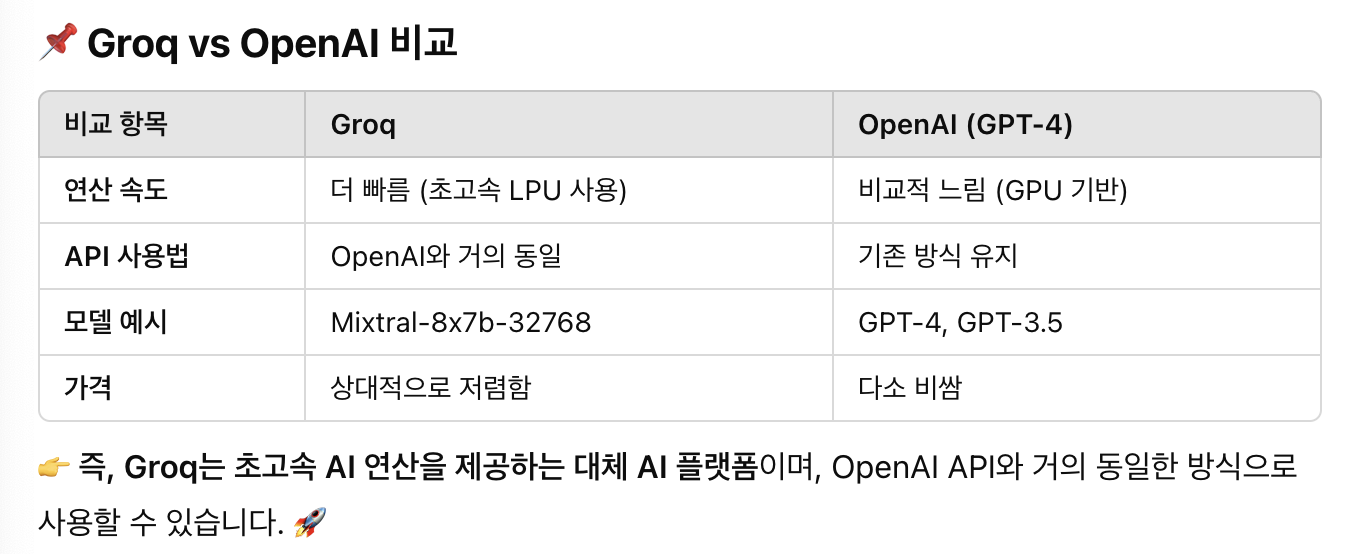

### 질문 추출 - `농사로 물갈이`

In [ ]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
import json # Q&A 데이터 json 파일로 저장 시 필요한 라이브러리
import requests # HTTP 요청 보낼 시 필요한 라이브러리(해당 코드 사용X)
from groq import Groq # Grop API 호출 라이브러리

# Groq API 키 설정
GROQ_API_KEY = "your_api_key"  # 🔒 API 키를 여기에 입력하세요.

# 질의응답 자동 생성 (10개 생성)
def generate_qa(text):
    prompt = f"""
    SFT를 위한 학습 데이터를 생성하려고 합니다.
    다음 내용을 기반으로 10개의 Q&A 세트를 만들어 주세요.
    Q&A 세트 형성 시 언어는 한국어로 해주세요.
    JSON 리스트 형태로 제공해주세요.

    형식 예시:
    [
        {{"question": "Q", "answer": "A"}},
        {{"question": "Q", "answer": "A"}}
    ]

    입력 데이터:
    {text}
    """
    # Groq API 입력
    client = Groq(api_key = GROQ_API_KEY)

    # Groq 챗봇 설정
    response = client.chat.completions.create(
        model = "mixtral-8x7b-32768",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7 # 0에 가까울수록 정형화, 1에 가까울수록 창의적인 답변 제공
    )

    # 응답을 JSON 형태로 변환 (문자열 → 리스트)
    try:
        qa_list = json.loads(response.choices[0].message.content) # 생성한 응답을 json 형식 리스트로 변환
    except json.JSONDecodeError as e:
        print("JSON 변환 오류:", e)
        qa_list = []  # 변환 실패 시 빈 리스트 반환

    return qa_list


# HTML에서 텍스트 추출 후 GPT에 입력 (실제 text 사용)
qa_list = generate_qa("식물에 물을 줄 때 가장 중요한 원칙은 무엇인가요?")  # 실제 HTML 데이터로 변경 필요

# JSON 저장 (올바른 리스트 형태)
with open("train_groq.json", "w", encoding="utf-8") as json_file: # train_grop.json 파일 생성
    json.dump(qa_list, json_file, ensure_ascii=False, indent=4) # qa_list 데이터 저장 / 한글 깨짐 방지, 들여쓰기 4칸

print("✅ Groq 기반 JSON 생성 완료! (Q&A 10개 저장)")


✅ Groq 기반 JSON 생성 완료! (Q&A 10개 저장)


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물의 물주기를 결정할 때 고려해야 할 요소는 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("겨울철과 여름철 물주기 방법은 어떻게 달라져야 하나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("물을 너무 많이 주었을 때 나타나는 문제는 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("물을 줄 때 한 번에 얼마나 줘야 하나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내 습도가 물주기에 미치는 영향은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물과 일반 식물의 물주기에서 가장 큰 차이점은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 물주기의 일반적인 법칙 -----

In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("화분에 물을 줄 때 배수구멍의 유무가 중요한 이유는 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("저면관수법과 침수법은 어떻게 다르며, 각각 어떤 상황에서 적절한가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("배수구가 없는 화분에서 올바르게 물을 주는 방법은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("겨울철 식물 물주기 시 주의해야 할 점은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("분무기를 이용한 물주기가 모든 식물에 적절한가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("식물의 크기와 잎의 형태에 따라 물주는 방식이 달라야 하는 이유는 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 물주기의 실제 -----

In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("식물에 물을 줄 적절한 시기를 어떻게 판단할 수 있나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

JSON 변환 오류: Expecting ':' delimiter: line 3 column 44 (char 197)
✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("토양이 건조한지 확인하는 가장 효과적인 방법은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("손가락을 이용한 토양 수분 테스트 방법은 어떻게 수행하나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("토양 수분 측정기를 활용한 물주기 시점 결정 방법은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("화분을 들어보는 방법으로 물주는 시기를 결정할 수 있나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("식물의 물 부족 증상과 과습 증상을 비교하여 물주는 시점을 조잘할 수 있나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 물주기의 올바른 시기 -----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

# 현재 작업 디렉토리에서 train_grop.json 파일을 Google Drive로 이동
shutil.copy('train_groq.json', '/content/drive/MyDrive/data/sft_datasettrain_groq.json')

'/content/drive/MyDrive/train_groq.json'

### 질문 추출 - `건조형 실내정원의 실제`

In [ ]:
import json # Q&A 데이터 json 파일로 저장 시 필요한 라이브러리
import requests # HTTP 요청 보낼 시 필요한 라이브러리(해당 코드 사용X)
from groq import Groq # Grop API 호출 라이브러리

# Groq API 키 설정
GROQ_API_KEY = "your_api_key"  # 🔒 API 키를 여기에 입력하세요.

# 질의응답 자동 생성 (10개 생성)
def generate_qa(text):
    prompt = f"""
    SFT를 위한 학습 데이터를 생성하려고 합니다.
    다음 내용을 기반으로 10개의 Q&A 세트를 만들어 주세요.
    Q&A 세트 형성 시 언어는 한국어로 해주세요.
    JSON 리스트 형태로 제공해주세요.

    형식 예시:
    [
        {{"question": "Q", "answer": "A"}},
        {{"question": "Q", "answer": "A"}}
    ]

    입력 데이터:
    {text}
    """
    # Groq API 입력
    client = Groq(api_key = GROQ_API_KEY)

    # Groq 챗봇 설정
    response = client.chat.completions.create(
        model = "mixtral-8x7b-32768",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7 # 0에 가까울수록 정형화, 1에 가까울수록 창의적인 답변 제공
    )

    # 응답을 JSON 형태로 변환 (문자열 → 리스트)
    try:
        qa_list = json.loads(response.choices[0].message.content) # 생성한 응답을 json 형식 리스트로 변환
    except json.JSONDecodeError as e:
        print("JSON 변환 오류:", e)
        qa_list = []  # 변환 실패 시 빈 리스트 반환

    return qa_list


# HTML에서 텍스트 추출 후 GPT에 입력 (실제 text 사용)
qa_list = generate_qa("다육식물이란 무엇인가요?")  # 실제 HTML 데이터로 변경 필요

# JSON 저장 (올바른 리스트 형태)
with open("train_groq_2.json", "w", encoding="utf-8") as json_file: # train_grop.json 파일 생성
    json.dump(qa_list, json_file, ensure_ascii=False, indent=4) # qa_list 데이터 저장 / 한글 깨짐 방지, 들여쓰기 4칸

print("✅ Groq 기반 JSON 생성 완료! (Q&A 10개 저장)")


✅ Groq 기반 JSON 생성 완료! (Q&A 10개 저장)


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물의 주요 습성은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물이 성장하는 데 필요한 환경 조건은 어떤 것들이 있나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

JSON 변환 오류: Invalid control character at: line 32 column 93 (char 1125)
✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물의 성장기와 휴면기의 차이점은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물에 물을 줄 때 주의해야 할 점은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물을 실내에서 키울 때 어떤 환경을 조성해야 하나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 다육식물의 기본정보 -----

In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물을 실내에서 키울 때 가장 중요한 선택 기준은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내에서 다육식물을 잘 키우려면 어떤 종류의 다육식물을 선택하는 것이 좋나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("여름과 겨울에 다육식물 관리가 달라지는 이유는 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물의 생장 속도와 환경적 요인이 어떻게 상호작용하나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물의 분갈이 최적기는 언제이며, 이를 고려한 선택이 중요한 이유는 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물의 생육 특성에 따라 계절별 관리가 어떻게 달라지나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내 다육식물의 배치 위치를 선택할 때 고려해야 할 주요 요소는 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 다육식물의 선택 (70개) -----

In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물에서 시든 잎을 어떻게 관리하나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물의 배치 장소는 어떻게 선택해야 하나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물을 기를 때 적합한 햇빛 조건은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("계절별 다육식물의 적정한 온도 및 습도와 관리 방법은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물에 비료는 얼마나 자주 주어야 하나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("다육식물에서 발생할 수 있는 병해충과 그 예방 방법은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 다육식물의 관리 -----

In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("심지관수법이란 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("심지관수 방식에서 가장 중요한 점은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("심지관수법을 이용한 다육식물 재배 방법은 어떻게 되나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("심지관수 방식이 기존의 물 주기 방식과 어떤 차이점이 있나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("심지관수에서 흙의 종류와 배양토의 역할, 그리고 흙의 습도 조절 방법은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_2.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("심지관수를 사용할 때, 화분 크기와 물 과다 공급을 방지하는 관리 방법은 어떻게 설정하나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 심지관수 -----

In [ ]:
import shutil

# 현재 작업 디렉토리에서 train_grop_2.json 파일을 Google Drive로 이동
shutil.copy('train_groq_2.json', '/content/drive/MyDrive/data/sft_datasettrain_groq(건조형 실내정원의 실제).json')

'/content/drive/MyDrive/train_groq(건조형 실내정원의 실제).json'

### 질문 생성 - `나만의 텃밭 가꾸기`

In [ ]:
import json # Q&A 데이터 json 파일로 저장 시 필요한 라이브러리
import requests # HTTP 요청 보낼 시 필요한 라이브러리(해당 코드 사용X)
from groq import Groq # Grop API 호출 라이브러리

# Groq API 키 설정
GROQ_API_KEY = "your_api_key"  # 🔒 API 키를 여기에 입력하세요.

# 질의응답 자동 생성 (10개 생성)
def generate_qa(text):
    prompt = f"""
    SFT를 위한 학습 데이터를 생성하려고 합니다.
    다음 내용을 기반으로 10개의 Q&A 세트를 만들어 주세요.
    Q&A 세트 형성 시 언어는 한국어로 해주세요.
    JSON 리스트 형태로 제공해주세요.

    형식 예시:
    [
        {{"question": "Q", "answer": "A"}},
        {{"question": "Q", "answer": "A"}}
    ]

    입력 데이터:
    {text}
    """
    # Groq API 입력
    client = Groq(api_key = GROQ_API_KEY)

    # Groq 챗봇 설정
    response = client.chat.completions.create(
        model = "mixtral-8x7b-32768",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7 # 0에 가까울수록 정형화, 1에 가까울수록 창의적인 답변 제공
    )

    # 응답을 JSON 형태로 변환 (문자열 → 리스트)
    try:
        qa_list = json.loads(response.choices[0].message.content) # 생성한 응답을 json 형식 리스트로 변환
    except json.JSONDecodeError as e:
        print("JSON 변환 오류:", e)
        qa_list = []  # 변환 실패 시 빈 리스트 반환

    return qa_list


# HTML에서 텍스트 추출 후 GPT에 입력 (실제 text 사용)
qa_list = generate_qa("텃밭 가꾸기의 주된 목적은 무엇이며, 도시농업과 일반농업의 주요 차이점은 무엇인가요?")  # 실제 HTML 데이터로 변경 필요

# JSON 저장 (올바른 리스트 형태)
with open("train_groq_3.json", "w", encoding="utf-8") as json_file: # train_grop.json 파일 생성
    json.dump(qa_list, json_file, ensure_ascii=False, indent=4) # qa_list 데이터 저장 / 한글 깨짐 방지, 들여쓰기 4칸

print("✅ Groq 기반 JSON 생성 완료! (Q&A 10개 저장)")


✅ Groq 기반 JSON 생성 완료! (Q&A 10개 저장)


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_3.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("텃밭 가꾸기가 주는 가치에는 무엇이 있나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

JSON 변환 오류: Unterminated string starting at: line 23 column 21 (char 989)
✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_3.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("텃밭 가꾸기가 주는 교육적, 경제적 효과는 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 텃밭 가꾸기 바로알기 -----

In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_3.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("텃밭을 가꾸기 전에 반드시 확인해야 할 환경 조건은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_3.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("도시농업에서 선택 가능한 다양한 텃밭 유형(베란다 텃밭, 옥상 텃밭, 주말농장 등)과 각 유형의 특징은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 텃밭 가꾸기의 첫걸음 -----

In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_3.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("텃밭을 시작할 때, 계절과 환경에 맞춰 어떤 작물을 선택해야 하나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_3.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내 텃밭과 실외 텃밭의 차이에 따라 선택 가능한 적합한 채소는 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 텃밭 작물 고르기 -----

In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_3.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("텃밭을 꾸밀 때, 동반식물을 활용하여 공간을 효율적으로 관리하는 방법은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_3.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("식물의 궁합을 고려하여 어떤 작물들을 함께 텃밭에 심으면 더 좋은 효과를 얻을 수 있나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 나만의 텃밭 꾸미기 -----

In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_3.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("텃밭의 물 관리와 잡초 제거는 어떻게 해야 텃밭 작물이 잘 자라게 할 수 있나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

JSON 변환 오류: Unterminated string starting at: line 12 column 19 (char 449)
✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_3.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("작물별 최적의 수확 시기를 어떻게 파악할 수 있고, 수확 방법은 어떻게 달라지나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 텃밭 관리 및 수확 -----

In [ ]:
import shutil

# 현재 작업 디렉토리에서 train_grop_2.json 파일을 Google Drive로 이동
shutil.copy('train_groq_3.json', '/content/drive/MyDrive/data/sft_datasettrain_groq(나만의 텃밭 가꾸기).json')

'/content/drive/MyDrive/train_groq(나만의 텃밭 가꾸기).json'

### 질문 생성 - 도시농업

In [ ]:
import json # Q&A 데이터 json 파일로 저장 시 필요한 라이브러리
import requests # HTTP 요청 보낼 시 필요한 라이브러리(해당 코드 사용X)
from groq import Groq # Grop API 호출 라이브러리

# Groq API 키 설정
GROQ_API_KEY = "your_api_key"  # 🔒 API 키를 여기에 입력하세요.

# 질의응답 자동 생성 (10개 생성)
def generate_qa(text):
    prompt = f"""
    SFT를 위한 학습 데이터를 생성하려고 합니다.
    다음 내용을 기반으로 10개의 Q&A 세트를 만들어 주세요.
    Q&A 세트 형성 시 언어는 한국어로 해주세요.
    JSON 리스트 형태로 제공해주세요.

    형식 예시:
    [
        {{"question": "Q", "answer": "A"}},
        {{"question": "Q", "answer": "A"}}
    ]

    입력 데이터:
    {text}
    """
    # Groq API 입력
    client = Groq(api_key = GROQ_API_KEY)

    # Groq 챗봇 설정
    response = client.chat.completions.create(
        model = "mixtral-8x7b-32768",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7 # 0에 가까울수록 정형화, 1에 가까울수록 창의적인 답변 제공
    )

    # 응답을 JSON 형태로 변환 (문자열 → 리스트)
    try:
        qa_list = json.loads(response.choices[0].message.content) # 생성한 응답을 json 형식 리스트로 변환
    except json.JSONDecodeError as e:
        print("JSON 변환 오류:", e)
        qa_list = []  # 변환 실패 시 빈 리스트 반환

    return qa_list


# HTML에서 텍스트 추출 후 GPT에 입력 (실제 text 사용)
qa_list = generate_qa("공중걸이용 식물을 고를 때 중요한 점은 무엇인가요?")  # 실제 HTML 데이터로 변경 필요

# JSON 저장 (올바른 리스트 형태)
with open("train_groq_4.json", "w", encoding="utf-8") as json_file: # train_grop.json 파일 생성
    json.dump(qa_list, json_file, ensure_ascii=False, indent=4) # qa_list 데이터 저장 / 한글 깨짐 방지, 들여쓰기 4칸

print("✅ Groq 기반 JSON 생성 완료! (Q&A 10개 저장)")


✅ Groq 기반 JSON 생성 완료! (Q&A 10개 저장)


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("창가에 배치할 실내식물을 고를 때 고려해야 할 점은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("공중걸이용 식물 종류에는 무엇이 있나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("창가이용 식물 종류에는 무엇이 있나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("공중걸이용과 창가이용 식물을 배치 시 고려해야 할 사항은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("남향 창가에 적합한 실내식물은 무엇이 있나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 고르는 요령 -----

In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("베란다에서 실내식물을 관리할 때 물주기는 어떻게 해야 하나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("베란다에서 실내식물의 습도 유지 방법에는 어떤 것들이 있나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물의 비료는 언제, 어떻게 주는 것이 좋은가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물에게 비료를 줄 때, 비료의 종류(액비, 고형비료, 화학비료, 유기질비료 등)에 따른 주의할 점은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("베란다에서 실내식물 기를 때, 해가리개를 사용해야 하는 이유는 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물의 해가리개는 어떻게 관리해야 하나요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 관리방법 -----

In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물을 기를 때 화분 분갈이를 하는 목적은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물 화분 분갈이 시기는 언제인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물 화분 분갈이 과정 중에 주의해야 할 점은 무엇인가요?")  # 새로운 질문 입력

# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물 화분 분갈이 시, 흙은 채우는 요령은 무엇인가요?")
# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

JSON 변환 오류: Unterminated string starting at: line 27 column 21 (char 1222)
✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물 화분 분갈이 후, 물을 줄 때 주의할 점이 무엇인가요?")
# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 화분 분갈이 -----

In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물의 생리장해에는 무엇인가요?")
# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물의 생리장해를 해결하는 방법에는 무엇이 있나요?")
# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물의 병해(바이러스병, 세균병 등)에는 무엇이 있으며, 감염 원인은 무엇인가요?")
# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물의 병해(바이러스병, 세균병 등) 해결 방식은 무엇인가요?")
# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물에서 해충 발생을 예방하기 위한 관리 방법은 무엇인가요?")
# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물의 물리적 방제와 화학적 방제 방법에는 무엇이 있나요?")
# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


In [ ]:
import json
import os

# 기존 파일 불러오기
file_path = "train_groq_4.json"

if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        try:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = []
        except json.JSONDecodeError:
            existing_data = []
else:
    existing_data = []

# 새 질문-답변 데이터 생성
new_qa_list = generate_qa("실내식물의 곰팡이, 해충 등을 예방하는 일상적인 관리 방법은 무엇인가요?")
# 기존 데이터에 새 데이터 추가
existing_data.extend(new_qa_list)

# JSON 파일로 저장 (누적됨)
with open(file_path, "w", encoding="utf-8") as json_file:
    json.dump(existing_data, json_file, ensure_ascii=False, indent=4)

print("✅ 데이터가 train_groq.json에 누적 저장되었습니다!")

✅ 데이터가 train_groq.json에 누적 저장되었습니다!


----- 병해충 방재 -----

In [ ]:
import shutil

# 현재 작업 디렉토리에서 train_grop_2.json 파일을 Google Drive로 이동
shutil.copy('train_groq_4.json', '/content/drive/MyDrive/data/sft_datasettrain_groq(도시농업).json')

'/content/drive/MyDrive/train_groq(도시농업).json'